# DR-HQCL: A Fusion of Supervised Contrastive Learning and Variational Quantum Classifiers

## 1. Environment Setup

### 1.1 Import Libraries

In [1]:
import os
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchsummary import summary
from torch.optim import lr_scheduler

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier

In [4]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

In [5]:
#from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit, transpile 
from qiskit.visualization import plot_bloch_multivector, plot_circuit_layout
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_aer import Aer
#from qiskit import BasicAer,execute
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import SPSA, COBYLA

In [6]:
from utility.plot import plot_roc, plot_confusion_matrix, plot_classification_report, plot_losses, plot_accuracies
from utility.dataset import load_dataset, get_stats, download_and_extract_data, SmallDataset, create_small_dataset, create_small_dataset_integer, get_data_class, convert_2048_features,scale_dataset, create_new_dataframe_and_save_csv
from utility.predict import get_accuracy, train_model
#from utility.predict import test_classifiers

In [7]:
import medmnist
from medmnist import INFO, Evaluator

In [8]:
import warnings
warnings.filterwarnings('ignore')

### 1.2. Set Random Seed Settings

In [9]:
torch.manual_seed(42)
np.random.seed(42)

### 1.3. Device Configurations

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.4 Creating Directories
Creating directories to store experiment results, machine learning models, and data.

In [41]:

results_dir = f"./experiments/+{str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"

if not os.path.exists(results_dir):
    # If not, create the folder
    os.makedirs(results_dir)
    print(f"Folder '{results_dir}' created successfully.")
else:
    print(f"Folder '{results_dir}' already exists.")

models_dir = f"./models/{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}/"

if not os.path.exists(models_dir):
    # If not, create the folder
    os.makedirs(models_dir)
    print(f"Folder '{models_dir}' created successfully.")
else:
    print(f"Folder '{models_dir}' already exists.")

data_dir = f"./data/"

if not os.path.exists(data_dir):
    # If not, create the folder
    os.makedirs(data_dir)
    print(f"Folder '{data_dir}' created successfully.")
else:
    print(f"Folder '{data_dir}' already exists.")

Folder './experiments/+2024_03_27_13_25_22/' created successfully.
Folder './models/2024_03_27_13_25_22/' created successfully.
Folder './data/' already exists.


### 1.5 Download Data
Download hymenoptera data and kaggle data

In [12]:
#destination_folder = "./data"

#hymenoptera_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
#cats_dogs_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

#download_and_extract_data(hymenoptera_url, destination_folder)
#download_and_extract_data(cats_dogs_url, destination_folder)

Data downloaded and extracted to './data' folder.


KeyboardInterrupt: 

## 2. Dataset Preparation

In [11]:
input_shape = (32, 32, 3)
learning_rate = 0.001
batch_size = 256
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.01
gamma_lr_scheduler = 0.01

### 2.1 Transform datasets

In [12]:
#preprocessing for train_loader_3
data_transforms = transforms.Compose([
    transforms.Resize((input_shape[0], input_shape[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 2.2 Create small datasets

#### 2.2.1 Create training and testing datasets for hymenoptera ants & bees

In [13]:
train_dataset_1, test_dataset_1, _, \
    _, dataset_sizes_1, class_names_1, y_train_1, y_test_1 = \
        load_dataset( input_shape, batch_size, "data/hymenoptera_data", data_transforms )

# encapsulate data into dataloader form
train_loader_1 = create_small_dataset_integer( 100, train_dataset_1, batch_size )
test_loader_1 = create_small_dataset_integer( 20, test_dataset_1, batch_size )

Training dataset size: 244
Testing datset size: 153


#### 2.2.2 Create training and testing datasets for kaglle cats & dogs

In [14]:
#import os
#import shutil
#import random

# Répertoire contenant les images de chats et de chiens
#data_dir = "data/PetImages"

# Répertoires pour les images d'entraînement et de validation
#train = os.path.join(data_dir, "train")
#val = os.path.join(data_dir, "val")

# Créer les répertoires s'ils n'existent pas déjà
#if not os.path.exists(train):
#    os.makedirs(train)
# if not os.path.exists(val):
#     os.makedirs(val)

# Répertoires pour les images de chats et de chiens
# dog_dir = os.path.join(data_dir, "Dog")
# cat_dir = os.path.join(data_dir, "Cat")

# Ratio pour la division des images en entraînement et validation
# train_ratio = 0.8

# Diviser les images de chats en entraînement et validation
# cat_files = os.listdir(cat_dir)
# num_cat_files = len(cat_files)
# num_train_cat = int(num_cat_files * train_ratio)
# num_val_cat = num_cat_files - num_train_cat
# train_cat_files = random.sample(cat_files, num_train_cat)
# val_cat_files = [f for f in cat_files if f not in train_cat_files]

# for f in train_cat_files:
#     src_file = os.path.join(cat_dir, f)
#     dst_file = os.path.join(train, "Cat", f)
#     shutil.copyfile(src_file, dst_file)

# for f in val_cat_files:
#     src_file = os.path.join(cat_dir, f)
#     dst_file = os.path.join(val, "Cat", f)
#     shutil.copyfile(src_file, dst_file)

# Diviser les images de chiens en entraînement et validation
# dog_files = os.listdir(dog_dir)
# num_dog_files = len(dog_files)
# num_train_dog = int(num_dog_files * train_ratio)
# num_val_dog = num_dog_files - num_train_dog
# train_dog_files = random.sample(dog_files, num_train_dog)
# val_dog_files = [f for f in dog_files if f not in train_dog_files]

# for f in train_dog_files:
#     src_file = os.path.join(dog_dir, f)
#     dst_file = os.path.join(train, "Dog", f)
#     shutil.copyfile(src_file, dst_file)

# for f in val_dog_files:
#     src_file = os.path.join(dog_dir, f)
#     dst_file = os.path.join(val, "Dog", f)
#     shutil.copyfile(src_file, dst_file)

In [15]:
train_dataset_2, test_dataset_2, _, \
    _, dataset_sizes_2, class_names_2, y_train_2, y_test_2 = \
        load_dataset( input_shape, batch_size, "data/PetImages", data_transforms )

train_loader_2 = create_small_dataset_integer( 100, train_dataset_2, batch_size )
test_loader_2 = create_small_dataset_integer( 20, test_dataset_2, batch_size )

Training dataset size: 20171
Testing datset size: 5000


#### 2.2.2 Create training and testing datasets for MedMNIST2D datasets
Below is a example of how to load 'breastmnist' MedMNIST2D dataset. This need to be done for 'PneumoniaMNIST', 'BreastMNIST', 'PathMNIST', 'ChestMNIST' datasets.

In [16]:
# preprocessing
data_transforms = transforms.Compose([
    transforms.Resize(input_shape[0]),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

In [17]:
# load the data
BreastMNISTDataClass = get_data_class('breastmnist')
train_dataset_3 = BreastMNISTDataClass(split='train', transform=data_transforms, download=True)
test_dataset_3 = BreastMNISTDataClass(split='test', transform=data_transforms, download=True)

train_loader_3 = create_small_dataset( 100, train_dataset_3, batch_size )
test_loader_3 = create_small_dataset( 20, test_dataset_3, batch_size )

Using downloaded and verified file: C:\Users\quent\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\quent\.medmnist\breastmnist.npz


In [18]:
# concatenated_dataset = ConcatDataset([train_loader.dataset, test_loader.dataset])
# merged_dataloader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

## 3. Hybrid Quantum-Classical Supervised Contrastive Learning

## 3.1 Classical supervised contrastive learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

![Classical Supervised Contrastive Learning](images/img_1.png)

## 3.2 Our Proposed Hybrid Quantum Classical Supervised Contrastive Learning Model (DR-HQCL)

![Hybrid Quantum-Classical Supervised Contrastive Learning](images/img_2.png)

### 3.3 Data augmentation

#### 3.3.1 Get mean, std details about all the datasets

In [19]:
#old total_mean_1, total_std_1 = get_stats(train_loader_1, test_loader_1, input_shape)
total_mean_1, total_std_1 = get_stats(train_loader_1, input_shape)
# todo: calculate mean, std for all other datasets.

mean: tensor([ 0.1152,  0.0584, -0.2241])
std:  tensor([1.0153, 0.9538, 1.0979])


In [20]:
total_mean_2, total_std_2 = get_stats(train_loader_2, input_shape)

mean: tensor([0.0004, 0.0001, 0.0004])
std:  tensor([0.1066, 0.1055, 0.1067])


In [21]:
total_mean_3, total_std_3 = get_stats(train_loader_3, input_shape)

mean: tensor([0.1194, 0.1194, 0.1194])
std:  tensor([0.2006, 0.2006, 0.2006])


#### 3.3.2 Create data augmentation layer with 5 operations

In [22]:
hFlip = transforms.RandomHorizontalFlip()
rRotation = transforms.RandomRotation(2)
rAffine = transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))
cJitter = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)  # Randomly adjust color

data_augmentation_1 = torch.nn.Sequential(
    transforms.Normalize(mean=total_mean_1, std=total_std_1),
    hFlip,
    rRotation,
    rAffine,
    cJitter
)

### 3.4 Build the classical encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [23]:
class Encoder(nn.Module):
    def __init__(self, data_augmentation, pretrained=False):
        super(Encoder, self).__init__()
        enc = models.resnet50(pretrained=pretrained)
        # Remove last layer
        enc.fc = nn.Identity()
        self.enc = enc
        self.data_augmentation = data_augmentation

    def forward(self, x):
        augmented = self.data_augmentation(x)
        outputs = self.enc(augmented)
        return outputs

### 3.5 Build projection head

In [24]:
class ProjectionHead(nn.Module):
    def __init__(self, encoder, projection_units):
        super(ProjectionHead, self).__init__()
        self.encoder = encoder
        self.fc1 = nn.Linear(2048, projection_units)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        features = self.encoder(x)
        outputs = self.relu1(self.fc1(features))
        return outputs

### 3.6 Build the classical neural network (NN) classification model for benchmarking

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [25]:
class Classifier(nn.Module):
    def __init__(self, encoder, hidden_units, num_classes, dropout_rate, trainable=True):
        super(Classifier, self).__init__()
        self.encoder = encoder
        if not trainable:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2048, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_classes)
        self.relu1 = nn.ReLU()
        self.softmax1 = nn.Softmax()

    def forward(self, x):
        features = self.encoder(x)
        features = self.dropout(features)
        features = self.relu1(self.fc1(features))
        features = self.dropout(features)
        outputs = self.softmax1(self.fc2(features))
        return outputs

### 3.7 Build variational quantum classification (VQC) model for benchmarking

#### 3.7.1 Create a log for the optimizer

In [26]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

#### 3.7.2 Build feature map for data encoding

In [27]:
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)

#### 3.7.3 Build variational circuit for learning

In [28]:
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

In [29]:


VQC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
VQC_CIRCUIT.measure_all()
VQC_CIRCUIT.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐ ░ »
«   q_0: ┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├┤ Rz(θ[10]) ├─░─»
«        ├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤├───────────┤ ░ »
«   q_1: ┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─»
«        └──────────┘   └──────────┘└──────────┘   └──────────┘└───────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌─┐   
«   q_0: ┤M├───
«        └╥┘┌─┐
«   q_1: ─╫─┤M├
«         ║ └╥┘
«meas: 2/═╩══╩═
«         0  1

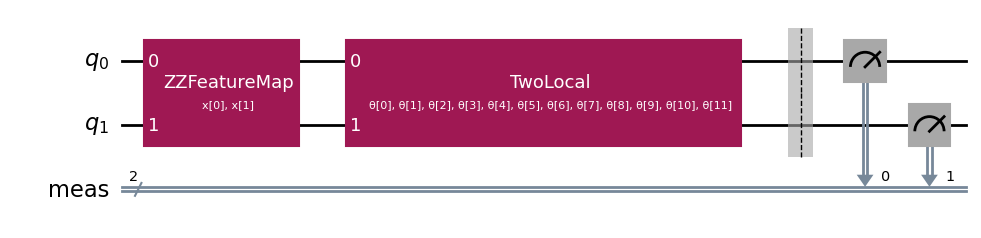

In [30]:
 VQC_CIRCUIT.draw(output='mpl', style='iqx')

## 4. Model training

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the variational quantum classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 4.1 Supervised contrastive learning loss function

In [31]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        print(self.temperature)

    def forward(self, feature_vectors, labels):
        print(feature_vectors.shape)
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(torch.matmul(feature_vectors_normalized, feature_vectors_normalized.t()), self.temperature)
        # Compute the loss using npairs_loss
        loss = F.cross_entropy( logits, labels.squeeze() )
        return loss

### 4.2 Pretrain the encoder and Save the model

In [32]:
encoder = Encoder(data_augmentation_1)

In [33]:
# Load saved model
# encoder.load_state_dict(torch.load('models/encoder'))

In [34]:
# Move the models to GPU if available
encoder.to(device);

In [35]:
# Create an instance of the encoder with projection head
encoder_with_projection_head = ProjectionHead(encoder, projection_units)

# Move the models to GPU if available
encoder_with_projection_head.to(device);

In [36]:
# Define the optimizer
encoderOptimizer = optim.Adam(encoder_with_projection_head.parameters(), lr=learning_rate)
# encoderOptimizer = optim.SGD(encoder_with_projection_head.parameters(), lr=learning_rate)
encoderCriterion = SupervisedContrastiveLoss(temperature=temperature)
encoder_exp_lr_scheduler = lr_scheduler.StepLR(
    encoderOptimizer, step_size=10, gamma=gamma_lr_scheduler
)

0.01


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# Training loop
train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
    train_model(encoder_with_projection_head, encoderCriterion, encoderOptimizer, \
                encoder_exp_lr_scheduler, train_loader_1, test_loader_1, num_epochs, \
                    validation=False, regularize=False)

torch.Size([200, 128])
Epoch [1/50], Train Loss: 37.1202, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [2/50], Train Loss: 6.2173, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [3/50], Train Loss: 4.4693, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [4/50], Train Loss: 4.3524, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [5/50], Train Loss: 4.3346, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [6/50], Train Loss: 4.5215, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [7/50], Train Loss: 4.7485, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [8/50], Train Loss: 4.3071, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [9/50], Train Loss: 4.3005, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [10/50], Train Loss: 4.4378, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [11/50], Train Loss: 4.5215, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [12/50], Train Loss: 4.2659, Train Accuracy: 0.0000
torch.Size([200, 128])
Epoch [13/50]

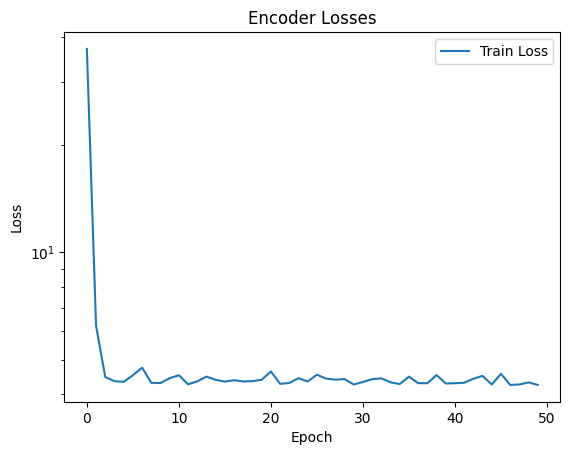

None


In [42]:
print(plot_losses(range(num_epochs), [
    train_loss_history
], ['Train Loss'], 'Encoder Losses', results_dir+"/enc_loss.png"))

In [43]:
torch.save(encoder_with_projection_head.state_dict(), models_dir+'/'+'encoder_with_projection_head')

In [44]:
torch.save(encoder.state_dict(), models_dir+'/'+'encoder')

### 4.3 Train the NN classifier with the frozen encoder

In [45]:
# Create an instance of the classifier
classifier = Classifier(encoder, hidden_units, len(class_names_1), dropout_rate, trainable=False)
# Move the models to GPU if available
classifier.to(device);

In [ ]:
# classifier.load_state_dict(torch.load(f'{models_dir}/classifier'))

In [46]:
classifierCriterion = nn.CrossEntropyLoss()
classifierOptimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
classifier_exp_lr_scheduler = lr_scheduler.StepLR(
    classifierOptimizer, step_size=5, gamma=gamma_lr_scheduler
)

In [47]:
train_loss_history2, train_acc_history2 = train_model(classifier, classifierCriterion, classifierOptimizer, classifier_exp_lr_scheduler, train_loader_1, test_loader_1, 100, regularize=False)

NameError: name 'torch' is not defined

In [ ]:
torch.save(classifier.state_dict(), f'{models_dir}/classifier')

In [ ]:
print(plot_losses(range(100), [
    train_loss_history2,
], ['Train Loss'], 'Classifier Losses (With Pre-Trained Auto-Encoder)', results_dir+"/with_ae_loss"))

NameError: name 'train_loss_history2' is not defined

In [ ]:
print(plot_accuracies(range(100), [
    train_acc_history2
], ['Train Accurcy'], 'Classifier Accuracies (With Pre-Trained Auto-Encoder)', results_dir+"/with_ae_acc.png"))

NameError: name 'train_acc_history2' is not defined

In [ ]:
# Make predictions
test_accuracy_1, y_test_pred_1, test_confidences_1 = get_accuracy( test_loader_1, device, classifier )

In [ ]:
# Make predictions
train_accuracy_1, y_train_pred_1, train_confidences_1 = get_accuracy( train_loader_1, device, classifier )

In [ ]:
# Plot the confusion matrix as a heatmap
plot_confusion_matrix(confusion_matrix(y_test_1, y_test_pred_1), results_dir+"with_ae_cm", classes=class_names_1, title='Confusion Matrix {}%'.format(test_accuracy_1))

ValueError: Found input variables with inconsistent numbers of samples: [153, 40]

In [ ]:
print(plot_classification_report(classification_report(y_test_1, y_test_pred_1), results_dir+"with_ae_cr"))

ValueError: Found input variables with inconsistent numbers of samples: [153, 40]

In [ ]:
from scipy.interpolate import interp
print(plot_roc(y_test_1, np.vstack([tensor.cpu().numpy() for tensor in test_confidences_1]), 2, 'Receiver operating characteristic', results_dir+"with_ae_roc.png"))

ImportError: cannot import name 'interp' from 'scipy.interpolate' (C:\Users\quent\AppData\Roaming\Python\Python312\site-packages\scipy\interpolate\__init__.py)

### 4.4 Training the VQC model

#### 4.4.1 Generate 2048 feature vector from pre-trained encoder

In [ ]:
x_2048_train_1, y_2048_train_1 = convert_2048_features(train_loader_1, device, encoder)
x_2048_test_1, y_2048_test_1 = convert_2048_features(test_loader_1, device, encoder)


#### 4.4.2 Scale the generated data

In [ ]:
x_2048_train_1 = scale_dataset(x_2048_train_1)
x_2048_test_1 = scale_dataset(x_2048_test_1)

In [ ]:
x_2048_train_1 = np.concatenate((x_2048_train_1, x_2048_test_1), axis=0)
y_2048_train_1 = np.concatenate((y_2048_train_1, y_2048_test_1), axis=0)

#### 4.4.3 Create new dataset using generated data

In [ ]:
merged_df_train_1 = create_new_dataframe_and_save_csv(x_2048_train_1, y_2048_train_1, 2048, models_dir, 'train_loader_1_df')
merged_df_test_1 = create_new_dataframe_and_save_csv(x_2048_test_1, y_2048_test_1, 2048, models_dir, 'test_loader_1_df')

In [ ]:
# merged_df_train_1.head()

In [ ]:
# X_train_2048, X_test_2048, y_train_2048, y_test_2048 = train_test_split(x_2048_train_1, y_2048_train_1, test_size=0.16, random_state=42, shuffle=False)

#### 4.4.4 Principal component analysis (PCA) to reduce feature dimension

##### 4.4.4.1 Transform 2048 features using PCA

In [ ]:
pca_30 = make_pipeline( PCA(n_components=100, random_state=42), MinMaxScaler() ) # scale data to min max range after pca
pca_30.fit(x_2048_train_1)
X_pca_30 = pca_30.transform(x_2048_train_1)

##### 4.4.4.2 Plot explained variance

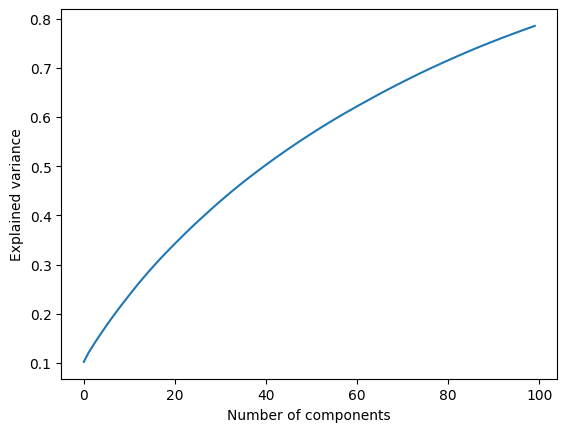

In [ ]:
plt.plot(np.cumsum(pca_30.get_params()['pca'].explained_variance_ratio_)) 
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 
plt.savefig('elbow_plot.png', dpi=100)

In [ ]:
pca_2 = make_pipeline( PCA(n_components=2, random_state=42), MinMaxScaler() )
pca_2.fit(x_2048_train_1)
X_train_pca_2_1 = pca_2.transform(x_2048_train_1)
X_test_pca_2_1 = pca_2.transform(x_2048_test_1)

### 4.5 Convert data labels using one-hot encoding

In [ ]:

oh_encoder = OneHotEncoder()
train_labels_oh = oh_encoder.fit_transform(y_2048_train_1.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = oh_encoder.fit_transform(y_2048_test_1.reshape(-1, 1)
                                      ).toarray()

### 4.6 Generate random initial points for gradient decent to avoid barren plateau problem

In [ ]:
initial_point = np.random.random(VAR_FORM.num_parameters)

### 4.7 Training VQC

In [ ]:
log = OptimizerLog()
vqc_1 = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA( callback=log.update ),
          initial_point=initial_point)

In [ ]:
vqc_1.fit(X_train_pca_2_1, train_labels_oh)

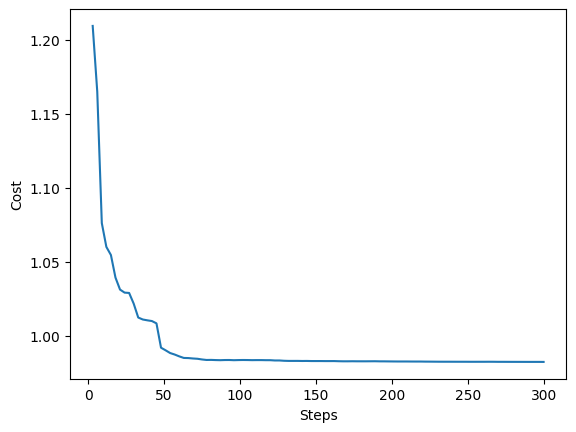

In [ ]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
# score == accuracy
vqc_accuracy_1 = vqc_1.score(X_test_pca_2_1, test_labels_oh)

In [ ]:
pred_test_labels_oh_1 = vqc_1.predict(X_test_pca_2_1)

In [ ]:
vqc_pred_test_labels_1 = np.argmax(pred_test_labels_oh_1, axis=1)

Confusion matrix, without normalization


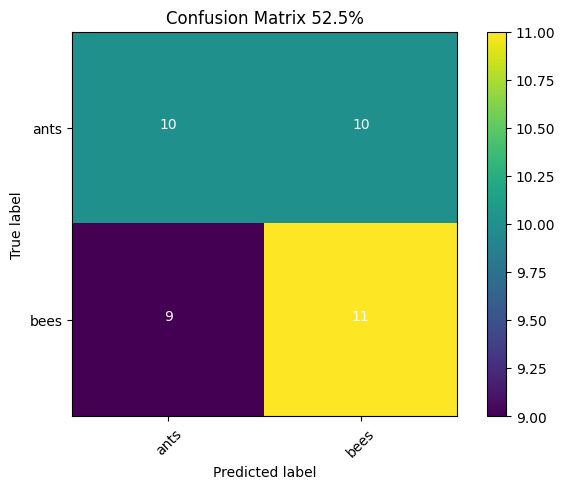

In [ ]:
# Plot the confusion matrix as a heatmap
plot_confusion_matrix(confusion_matrix(y_2048_test_1, vqc_pred_test_labels_1), results_dir+"with_VQC_cm.png", classes=class_names_1, title='Confusion Matrix {}%'.format(vqc_accuracy_1*100))